### Data separation, library import and important functions

In [1]:
### --- importing dependences ---- ###
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import xgboost as xgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import shap
import matplotlib.pyplot as plt
import csv
import time
import os
import joblib
import numpy as np
import seaborn as sns
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Descriptors import *
from rdkit.Chem.rdMolDescriptors import *
from rdkit.Chem.Lipinski import *
from rdkit.Chem.EState import *
from rdkit.Chem.GraphDescriptors import *
from rdkit.Chem.Graphs import *
from math import sqrt, ceil


rad = 2
nbit = 2048
n_est = 1000
sizeleaf = 5
m_fac = 683


C:\Users\Usuário\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### important functions
def grafic(y_test, y_pred,y_test2, y_pred2, color):
    plt.plot(y_test, y_test, linestyle='--', color='white', label='y = x')
    plt.scatter(y_test, y_pred, alpha=0.5, color=color, label='Pontos de Teste vs. Previsões')
    plt.scatter(y_test2, y_pred2, alpha=0.5, color='black', marker='x', label='Pontos de treinamento vs. Previsões')
    plt.title('')
    plt.xlabel('Energia Dados')
    plt.ylabel('Energia RF')
    plt.legend('')
    plt.grid(True)
    plt.show()
    
def flatten_list(lst):
    flat_list = []
    for item in lst:
        if isinstance(item, list):
            flat_list.extend(flatten_list(item))
        else:
            flat_list.append(item)
    return flat_list

def calcular_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calcular_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def avaliar_modelo(y_true, y_pred):
    resultados = {}

    resultados['MAE'] = mean_absolute_error(y_true, y_pred)
    resultados['MSE'] = mean_squared_error(y_true, y_pred)
    resultados['RMSE'] = calcular_rmse(y_true, y_pred)
    resultados['R2'] = r2_score(y_true, y_pred)
    resultados['MAPE'] = calcular_mape(y_true, y_pred)

    return resultados

def properties_array(sSmiles):
    try:
        m = Chem.MolFromSmiles(sSmiles)
        p1 = AllChem.GetMorganFingerprintAsBitVect(m, 2, 512)
        p2 = Chem.rdMolDescriptors.GetMACCSKeysFingerprint(m)

        p3 = [1000*FpDensityMorgan1(m), 1000*FpDensityMorgan2(m), 1000*FpDensityMorgan3(m), ExactMolWt(m), HeavyAtomMolWt(m), 1000*MaxAbsPartialCharge(m), 1000*MaxPartialCharge(m), 1000*MinAbsPartialCharge(m), 1000*MinPartialCharge(m), NumRadicalElectrons(m), NumValenceElectrons(m),1000*CalcFractionCSP3(m),10*CalcKappa1(m),10*CalcKappa2(m),10*CalcKappa3(m),CalcLabuteASA(m),CalcNumAliphaticCarbocycles(m),CalcNumAliphaticHeterocycles(m),CalcNumAliphaticRings(m),CalcNumAmideBonds(m),CalcNumAromaticCarbocycles(m),CalcNumAromaticHeterocycles(m),CalcNumAromaticRings(m),CalcNumAtomStereoCenters(m),CalcNumBridgeheadAtoms(m),CalcNumHBA(m),CalcNumHBD(m),CalcNumHeteroatoms(m),CalcNumHeterocycles(m),CalcNumLipinskiHBA(m),CalcNumLipinskiHBD(m),CalcNumRings(m),CalcNumRotatableBonds(m),CalcNumSaturatedCarbocycles(m),CalcNumSaturatedHeterocycles(m),CalcNumSaturatedRings(m),CalcNumSpiroAtoms(m),CalcNumUnspecifiedAtomStereoCenters(m),CalcTPSA(m)]
        pa3 = np.array(p3, dtype=np.int16)
        
        p4 = [HeavyAtomCount(m), NHOHCount(m), NOCount(m),NumHAcceptors(m), NumHDonors(m), Chi0(m), Chi1(m)]
        
        p5 = [rdMolDescriptors.BCUT2D(m)]

        pa1 = np.array(list(p1), dtype=np.int16)
        pa2 = np.array(list(p2), dtype=np.int16)
        pa0 = np.concatenate([pa1, pa2])
        pa4 = np.array(p4, dtype=np.int16)
        pa5 = np.array(flatten_list(p5), dtype=np.int16)
        
        pa = np.concatenate([pa0,pa3, pa4,pa5])
        #print(len(pa))

        pa = np.array(pa)

        return pa, True
    except Exception as e:
        print(f"Ocorreu um erro: {e}")
        return None, False

In [3]:
### Data separation
csv_file_path = "DATA/DB.csv"
print('Separação dos dados iniciada. ', time.ctime())
inicio = time.ctime()
paWl_list = []
paQY_list = []
Wl_list = []
QY_list = []

with open(csv_file_path , "r") as csvfile:
    csv_reader = csv.reader(csvfile)
    next(csv_reader, None)

    rows = list(csv_reader)
    for row in rows:
        Wl = float(row[4])
        QY = float(row[6])

        sSmiles = row[1]
        sSmilesSolvent = row[2]

        pa, lCano = properties_array(sSmiles)
        pa2, lCano2 = properties_array(sSmilesSolvent)

        if Wl > 0:

          if not (row[4] == "NaN" or np.isnan(Wl)):
              if (pa is not None and np.any(pa != None)) or (lCano2 is not None and np.any(lCano2 != None)):
                  if Wl < 1000 and (pa is not None and pa.ndim > 0) and (pa2 is not None and pa2.ndim > 0):
                      paWl_list.append(np.concatenate([np.atleast_1d(pa), np.atleast_1d(pa2)]))
                      Wl_list.append(round(Wl))

        if QY > 0:
            if not (row[6] == "NaN" or np.isnan(QY)):
                if (pa is not None and np.any(pa != None)) or (lCano2 is not None and np.any(lCano2 != None)):
                    if (pa is not None and pa.ndim > 0) and (pa2 is not None and pa2.ndim > 0):
                        if QY > 1:
                            paQY_list.append(np.concatenate([np.atleast_1d(pa), np.atleast_1d(pa2)]))
                            QY_list.append(QY/1000)
                        else:
                            paQY_list.append(np.concatenate([np.atleast_1d(pa), np.atleast_1d(pa2)]))
                            QY_list.append(QY)



Separação dos dados iniciada.  Tue Mar 11 10:00:32 2025
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN t

[10:02:44] SMILES Parse Error: syntax error while parsing: gas
[10:02:44] SMILES Parse Error: Failed parsing SMILES 'gas' for input: 'gas'


Ocorreu um erro: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(NoneType, int, int)
did not match C++ signature:
    GetMorganFingerprintAsBitVect(class RDKit::ROMol mol, unsigned int radius, unsigned int nBits=2048, class boost::python::api::object invariants=[], class boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, class boost::python::api::object bitInfo=None, bool includeRedundantEnvironments=False)
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um erro: cannot convert float NaN to integer
Ocorreu um

[10:03:00] SMILES Parse Error: syntax error while parsing: gas
[10:03:00] SMILES Parse Error: Failed parsing SMILES 'gas' for input: 'gas'


Ocorreu um erro: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(NoneType, int, int)
did not match C++ signature:
    GetMorganFingerprintAsBitVect(class RDKit::ROMol mol, unsigned int radius, unsigned int nBits=2048, class boost::python::api::object invariants=[], class boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, class boost::python::api::object bitInfo=None, bool includeRedundantEnvironments=False)


[10:03:03] SMILES Parse Error: syntax error while parsing: gas
[10:03:03] SMILES Parse Error: Failed parsing SMILES 'gas' for input: 'gas'
[10:03:03] SMILES Parse Error: syntax error while parsing: gas
[10:03:03] SMILES Parse Error: Failed parsing SMILES 'gas' for input: 'gas'
[10:03:03] SMILES Parse Error: syntax error while parsing: gas
[10:03:03] SMILES Parse Error: Failed parsing SMILES 'gas' for input: 'gas'
[10:03:03] SMILES Parse Error: syntax error while parsing: gas
[10:03:03] SMILES Parse Error: Failed parsing SMILES 'gas' for input: 'gas'
[10:03:03] SMILES Parse Error: syntax error while parsing: gas
[10:03:03] SMILES Parse Error: Failed parsing SMILES 'gas' for input: 'gas'
[10:03:03] SMILES Parse Error: syntax error while parsing: gas
[10:03:03] SMILES Parse Error: Failed parsing SMILES 'gas' for input: 'gas'
[10:03:03] SMILES Parse Error: syntax error while parsing: gas
[10:03:03] SMILES Parse Error: Failed parsing SMILES 'gas' for input: 'gas'
[10:03:03] SMILES Parse Err

Ocorreu um erro: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(NoneType, int, int)
did not match C++ signature:
    GetMorganFingerprintAsBitVect(class RDKit::ROMol mol, unsigned int radius, unsigned int nBits=2048, class boost::python::api::object invariants=[], class boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, class boost::python::api::object bitInfo=None, bool includeRedundantEnvironments=False)
Ocorreu um erro: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(NoneType, int, int)
did not match C++ signature:
    GetMorganFingerprintAsBitVect(class RDKit::ROMol mol, unsigned int radius, unsigned int nBits=2048, class boost::python::api::object invariants=[], class boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, class boost::python::api::object bitInfo=None, bool includeRed

In [4]:
# Data standardization
Wl_list = np.array(Wl_list)
QY_list = np.array(QY_list)
paWl_list = np.array(paWl_list)
paQY_list = np.array(paQY_list)

X_train_WL, X_test_WL, y_train_WL, y_test_WL = train_test_split(paWl_list, Wl_list, test_size=0.3, random_state=200)
X_train_QY, X_test_QY, y_train_QY, y_test_QY = train_test_split(paQY_list, QY_list, test_size=0.3, random_state=200)

scaler1 = StandardScaler()
scaler1.fit(X_train_WL)  # Ajusta no treino
X_train_WL_scaled = scaler1.transform(X_train_WL)  # Transforma treino
X_test_WL_scaled = scaler1.transform(X_test_WL)  # Aplica no teste

joblib.dump(scaler1, 'scaler_modelwl.pkl')

scaler2 = StandardScaler()
scaler2.fit(X_train_QY)  # Ajusta no treino
X_train_QY_scaled = scaler2.transform(X_train_QY)  # Transforma treino
X_test_QY_scaled = scaler2.transform(X_test_QY)  # Aplica no teste

joblib.dump(scaler2, 'scaler_model-QY.pkl')

print("Data separation and normalization completed.")
print(len(Wl_list), len(QY_list), len(X_train_WL_scaled), len(X_test_WL_scaled))
print(len(X_train_QY_scaled), len(X_test_QY_scaled))

Data separation and normalization completed.
18079 13685 12655 5424
9579 4106


In [5]:
### Header of data with RDKit
header3 = ['Morgan_0', 'Morgan_1', 'Morgan_2', 'Morgan_3', 'Morgan_4', 'Morgan_5', 'Morgan_6', 'Morgan_7', 'Morgan_8', 'Morgan_9', 'Morgan_10', 'Morgan_11', 'Morgan_12', 'Morgan_13', 'Morgan_14', 'Morgan_15', 'Morgan_16', 'Morgan_17', 'Morgan_18', 'Morgan_19', 'Morgan_20', 'Morgan_21', 'Morgan_22', 'Morgan_23', 'Morgan_24', 'Morgan_25', 'Morgan_26', 'Morgan_27', 'Morgan_28', 'Morgan_29', 'Morgan_30', 'Morgan_31', 'Morgan_32', 'Morgan_33', 'Morgan_34', 'Morgan_35', 'Morgan_36', 'Morgan_37', 'Morgan_38', 'Morgan_39', 'Morgan_40', 'Morgan_41', 'Morgan_42', 'Morgan_43', 'Morgan_44', 'Morgan_45', 'Morgan_46', 'Morgan_47', 'Morgan_48', 'Morgan_49', 'Morgan_50', 'Morgan_51', 'Morgan_52', 'Morgan_53', 'Morgan_54', 'Morgan_55', 'Morgan_56', 'Morgan_57', 'Morgan_58', 'Morgan_59', 'Morgan_60', 'Morgan_61', 'Morgan_62', 'Morgan_63', 'Morgan_64', 'Morgan_65', 'Morgan_66', 'Morgan_67', 'Morgan_68', 'Morgan_69', 'Morgan_70', 'Morgan_71', 'Morgan_72', 'Morgan_73', 'Morgan_74', 'Morgan_75', 'Morgan_76', 'Morgan_77', 'Morgan_78', 'Morgan_79', 'Morgan_80', 'Morgan_81', 'Morgan_82', 'Morgan_83', 'Morgan_84', 'Morgan_85', 'Morgan_86', 'Morgan_87', 'Morgan_88', 'Morgan_89', 'Morgan_90', 'Morgan_91', 'Morgan_92', 'Morgan_93', 'Morgan_94', 'Morgan_95', 'Morgan_96', 'Morgan_97', 'Morgan_98', 'Morgan_99', 'Morgan_100', 'Morgan_101', 'Morgan_102', 'Morgan_103', 'Morgan_104', 'Morgan_105', 'Morgan_106', 'Morgan_107', 'Morgan_108', 'Morgan_109', 'Morgan_110', 'Morgan_111', 'Morgan_112', 'Morgan_113', 'Morgan_114', 'Morgan_115', 'Morgan_116', 'Morgan_117', 'Morgan_118', 'Morgan_119', 'Morgan_120', 'Morgan_121', 'Morgan_122', 'Morgan_123', 'Morgan_124', 'Morgan_125', 'Morgan_126', 'Morgan_127', 'Morgan_128', 'Morgan_129', 'Morgan_130', 'Morgan_131', 'Morgan_132', 'Morgan_133', 'Morgan_134', 'Morgan_135', 'Morgan_136', 'Morgan_137', 'Morgan_138', 'Morgan_139', 'Morgan_140', 'Morgan_141', 'Morgan_142', 'Morgan_143', 'Morgan_144', 'Morgan_145', 'Morgan_146', 'Morgan_147', 'Morgan_148', 'Morgan_149', 'Morgan_150', 'Morgan_151', 'Morgan_152', 'Morgan_153', 'Morgan_154', 'Morgan_155', 'Morgan_156', 'Morgan_157', 'Morgan_158', 'Morgan_159', 'Morgan_160', 'Morgan_161', 'Morgan_162', 'Morgan_163', 'Morgan_164', 'Morgan_165', 'Morgan_166', 'Morgan_167', 'Morgan_168', 'Morgan_169', 'Morgan_170', 'Morgan_171', 'Morgan_172', 'Morgan_173', 'Morgan_174', 'Morgan_175', 'Morgan_176', 'Morgan_177', 'Morgan_178', 'Morgan_179', 'Morgan_180', 'Morgan_181', 'Morgan_182', 'Morgan_183', 'Morgan_184', 'Morgan_185', 'Morgan_186', 'Morgan_187', 'Morgan_188', 'Morgan_189', 'Morgan_190', 'Morgan_191', 'Morgan_192', 'Morgan_193', 'Morgan_194', 'Morgan_195', 'Morgan_196', 'Morgan_197', 'Morgan_198', 'Morgan_199', 'Morgan_200', 'Morgan_201', 'Morgan_202', 'Morgan_203', 'Morgan_204', 'Morgan_205', 'Morgan_206', 'Morgan_207', 'Morgan_208', 'Morgan_209', 'Morgan_210', 'Morgan_211', 'Morgan_212', 'Morgan_213', 'Morgan_214', 'Morgan_215', 'Morgan_216', 'Morgan_217', 'Morgan_218', 'Morgan_219', 'Morgan_220', 'Morgan_221', 'Morgan_222', 'Morgan_223', 'Morgan_224', 'Morgan_225', 'Morgan_226', 'Morgan_227', 'Morgan_228', 'Morgan_229', 'Morgan_230', 'Morgan_231', 'Morgan_232', 'Morgan_233', 'Morgan_234', 'Morgan_235', 'Morgan_236', 'Morgan_237', 'Morgan_238', 'Morgan_239', 'Morgan_240', 'Morgan_241', 'Morgan_242', 'Morgan_243', 'Morgan_244', 'Morgan_245', 'Morgan_246', 'Morgan_247', 'Morgan_248', 'Morgan_249', 'Morgan_250', 'Morgan_251', 'Morgan_252', 'Morgan_253', 'Morgan_254', 'Morgan_255', 'Morgan_256', 'Morgan_257', 'Morgan_258', 'Morgan_259', 'Morgan_260', 'Morgan_261', 'Morgan_262', 'Morgan_263', 'Morgan_264', 'Morgan_265', 'Morgan_266', 'Morgan_267', 'Morgan_268', 'Morgan_269', 'Morgan_270', 'Morgan_271', 'Morgan_272', 'Morgan_273', 'Morgan_274', 'Morgan_275', 'Morgan_276', 'Morgan_277', 'Morgan_278', 'Morgan_279', 'Morgan_280', 'Morgan_281', 'Morgan_282', 'Morgan_283', 'Morgan_284', 'Morgan_285', 'Morgan_286', 'Morgan_287', 'Morgan_288', 'Morgan_289', 'Morgan_290', 'Morgan_291', 'Morgan_292', 'Morgan_293', 'Morgan_294', 'Morgan_295', 'Morgan_296', 'Morgan_297', 'Morgan_298', 'Morgan_299', 'Morgan_300', 'Morgan_301', 'Morgan_302', 'Morgan_303', 'Morgan_304', 'Morgan_305', 'Morgan_306', 'Morgan_307', 'Morgan_308', 'Morgan_309', 'Morgan_310', 'Morgan_311', 'Morgan_312', 'Morgan_313', 'Morgan_314', 'Morgan_315', 'Morgan_316', 'Morgan_317', 'Morgan_318', 'Morgan_319', 'Morgan_320', 'Morgan_321', 'Morgan_322', 'Morgan_323', 'Morgan_324', 'Morgan_325', 'Morgan_326', 'Morgan_327', 'Morgan_328', 'Morgan_329', 'Morgan_330', 'Morgan_331', 'Morgan_332', 'Morgan_333', 'Morgan_334', 'Morgan_335', 'Morgan_336', 'Morgan_337', 'Morgan_338', 'Morgan_339', 'Morgan_340', 'Morgan_341', 'Morgan_342', 'Morgan_343', 'Morgan_344', 'Morgan_345', 'Morgan_346', 'Morgan_347', 'Morgan_348', 'Morgan_349', 'Morgan_350', 'Morgan_351', 'Morgan_352', 'Morgan_353', 'Morgan_354', 'Morgan_355', 'Morgan_356', 'Morgan_357', 'Morgan_358', 'Morgan_359', 'Morgan_360', 'Morgan_361', 'Morgan_362', 'Morgan_363', 'Morgan_364', 'Morgan_365', 'Morgan_366', 'Morgan_367', 'Morgan_368', 'Morgan_369', 'Morgan_370', 'Morgan_371', 'Morgan_372', 'Morgan_373', 'Morgan_374', 'Morgan_375', 'Morgan_376', 'Morgan_377', 'Morgan_378', 'Morgan_379', 'Morgan_380', 'Morgan_381', 'Morgan_382', 'Morgan_383', 'Morgan_384', 'Morgan_385', 'Morgan_386', 'Morgan_387', 'Morgan_388', 'Morgan_389', 'Morgan_390', 'Morgan_391', 'Morgan_392', 'Morgan_393', 'Morgan_394', 'Morgan_395', 'Morgan_396', 'Morgan_397', 'Morgan_398', 'Morgan_399', 'Morgan_400', 'Morgan_401', 'Morgan_402', 'Morgan_403', 'Morgan_404', 'Morgan_405', 'Morgan_406', 'Morgan_407', 'Morgan_408', 'Morgan_409', 'Morgan_410', 'Morgan_411', 'Morgan_412', 'Morgan_413', 'Morgan_414', 'Morgan_415', 'Morgan_416', 'Morgan_417', 'Morgan_418', 'Morgan_419', 'Morgan_420', 'Morgan_421', 'Morgan_422', 'Morgan_423', 'Morgan_424', 'Morgan_425', 'Morgan_426', 'Morgan_427', 'Morgan_428', 'Morgan_429', 'Morgan_430', 'Morgan_431', 'Morgan_432', 'Morgan_433', 'Morgan_434', 'Morgan_435', 'Morgan_436', 'Morgan_437', 'Morgan_438', 'Morgan_439', 'Morgan_440', 'Morgan_441', 'Morgan_442', 'Morgan_443', 'Morgan_444', 'Morgan_445', 'Morgan_446', 'Morgan_447', 'Morgan_448', 'Morgan_449', 'Morgan_450', 'Morgan_451', 'Morgan_452', 'Morgan_453', 'Morgan_454', 'Morgan_455', 'Morgan_456', 'Morgan_457', 'Morgan_458', 'Morgan_459', 'Morgan_460', 'Morgan_461', 'Morgan_462', 'Morgan_463', 'Morgan_464', 'Morgan_465', 'Morgan_466', 'Morgan_467', 'Morgan_468', 'Morgan_469', 'Morgan_470', 'Morgan_471', 'Morgan_472', 'Morgan_473', 'Morgan_474', 'Morgan_475', 'Morgan_476', 'Morgan_477', 'Morgan_478', 'Morgan_479', 'Morgan_480', 'Morgan_481', 'Morgan_482', 'Morgan_483', 'Morgan_484', 'Morgan_485', 'Morgan_486', 'Morgan_487', 'Morgan_488', 'Morgan_489', 'Morgan_490', 'Morgan_491', 'Morgan_492', 'Morgan_493', 'Morgan_494', 'Morgan_495', 'Morgan_496', 'Morgan_497', 'Morgan_498', 'Morgan_499', 'Morgan_500', 'Morgan_501', 'Morgan_502', 'Morgan_503', 'Morgan_504', 'Morgan_505', 'Morgan_506', 'Morgan_507', 'Morgan_508', 'Morgan_509', 'Morgan_510', 'Morgan_511', 'MACCS_0', 'MACCS_1', 'MACCS_2', 'MACCS_3', 'MACCS_4', 'MACCS_5', 'MACCS_6', 'MACCS_7', 'MACCS_8', 'MACCS_9', 'MACCS_10', 'MACCS_11', 'MACCS_12', 'MACCS_13', 'MACCS_14', 'MACCS_15', 'MACCS_16', 'MACCS_17', 'MACCS_18', 'MACCS_19', 'MACCS_20', 'MACCS_21', 'MACCS_22', 'MACCS_23', 'MACCS_24', 'MACCS_25', 'MACCS_26', 'MACCS_27', 'MACCS_28', 'MACCS_29', 'MACCS_30', 'MACCS_31', 'MACCS_32', 'MACCS_33', 'MACCS_34', 'MACCS_35', 'MACCS_36', 'MACCS_37', 'MACCS_38', 'MACCS_39', 'MACCS_40', 'MACCS_41', 'MACCS_42', 'MACCS_43', 'MACCS_44', 'MACCS_45', 'MACCS_46', 'MACCS_47', 'MACCS_48', 'MACCS_49', 'MACCS_50', 'MACCS_51', 'MACCS_52', 'MACCS_53', 'MACCS_54', 'MACCS_55', 'MACCS_56', 'MACCS_57', 'MACCS_58', 'MACCS_59', 'MACCS_60', 'MACCS_61', 'MACCS_62', 'MACCS_63', 'MACCS_64', 'MACCS_65', 'MACCS_66', 'MACCS_67', 'MACCS_68', 'MACCS_69', 'MACCS_70', 'MACCS_71', 'MACCS_72', 'MACCS_73', 'MACCS_74', 'MACCS_75', 'MACCS_76', 'MACCS_77', 'MACCS_78', 'MACCS_79', 'MACCS_80', 'MACCS_81', 'MACCS_82', 'MACCS_83', 'MACCS_84', 'MACCS_85', 'MACCS_86', 'MACCS_87', 'MACCS_88', 'MACCS_89', 'MACCS_90', 'MACCS_91', 'MACCS_92', 'MACCS_93', 'MACCS_94', 'MACCS_95', 'MACCS_96', 'MACCS_97', 'MACCS_98', 'MACCS_99', 'MACCS_100', 'MACCS_101', 'MACCS_102', 'MACCS_103', 'MACCS_104', 'MACCS_105', 'MACCS_106', 'MACCS_107', 'MACCS_108', 'MACCS_109', 'MACCS_110', 'MACCS_111', 'MACCS_112', 'MACCS_113', 'MACCS_114', 'MACCS_115', 'MACCS_116', 'MACCS_117', 'MACCS_118', 'MACCS_119', 'MACCS_120', 'MACCS_121', 'MACCS_122', 'MACCS_123', 'MACCS_124', 'MACCS_125', 'MACCS_126', 'MACCS_127', 'MACCS_128', 'MACCS_129', 'MACCS_130', 'MACCS_131', 'MACCS_132', 'MACCS_133', 'MACCS_134', 'MACCS_135', 'MACCS_136', 'MACCS_137', 'MACCS_138', 'MACCS_139', 'MACCS_140', 'MACCS_141', 'MACCS_142', 'MACCS_143', 'MACCS_144', 'MACCS_145', 'MACCS_146', 'MACCS_147', 'MACCS_148', 'MACCS_149', 'MACCS_150', 'MACCS_151', 'MACCS_152', 'MACCS_153', 'MACCS_154', 'MACCS_155', 'MACCS_156', 'MACCS_157', 'MACCS_158', 'MACCS_159', 'MACCS_160', 'MACCS_161', 'MACCS_162', 'MACCS_163', 'MACCS_164', 'MACCS_165', 'MACCS_166', "FpDensityMorgan1"," FpDensityMorgan2"," FpDensityMorgan3"," ExactMolWt"," HeavyAtomMolWt"," MaxAbsPartialCharge"," MaxPartialCharge"," MinAbsPartialCharge"," MinPartialCharge","NumRadicalElectrons"," NumValenceElectrons","CalcFractionCSP3","CalcKappa1","CalcKappa2","CalcKappa3","CalcLabuteASA","CalcNumAliphaticCarbocycles","CalcNumAliphaticHeterocycles","CalcNumAliphaticRings","CalcNumAmideBonds","CalcNumAromaticCarbocycles","CalcNumAromaticHeterocycles","CalcNumAromaticRings","CalcNumAtomStereoCenters","CalcNumBridgeheadAtoms","CalcNumHBA","CalcNumHBD","CalcNumHeteroatoms","CalcNumHeterocycles","CalcNumLipinskiHBA","CalcNumLipinskiHBD","CalcNumRings","CalcNumRotatableBonds","CalcNumSaturatedCarbocycles","CalcNumSaturatedHeterocycles","CalcNumSaturatedRings","CalcNumSpiroAtoms","CalcNumUnspecifiedAtomStereoCenters","CalcTPSA","HeavyAtomCount","NHOHCount","NOCount","NumHAcceptors","NumHDonors","Chi0","Chi1", 'BCUT2D_0', 'BCUT2D_1', 'BCUT2D_2','BCUT2D_3', 'BCUT2D_4', 'BCUT2D_5', 'BCUT2D_6', 'BCUT2D_7','2morgan_0', '2morgan_1', '2morgan_2', '2morgan_3', '2morgan_4', '2morgan_5', '2morgan_6', '2morgan_7', '2morgan_8', '2morgan_9', '2morgan_10', '2morgan_11', '2morgan_12', '2morgan_13', '2morgan_14', '2morgan_15', '2morgan_16', '2morgan_17', '2morgan_18', '2morgan_19', '2morgan_20', '2morgan_21', '2morgan_22', '2morgan_23', '2morgan_24', '2morgan_25', '2morgan_26', '2morgan_27', '2morgan_28', '2morgan_29', '2morgan_30', '2morgan_31', '2morgan_32', '2morgan_33', '2morgan_34', '2morgan_35', '2morgan_36', '2morgan_37', '2morgan_38', '2morgan_39', '2morgan_40', '2morgan_41', '2morgan_42', '2morgan_43', '2morgan_44', '2morgan_45', '2morgan_46', '2morgan_47', '2morgan_48', '2morgan_49', '2morgan_50', '2morgan_51', '2morgan_52', '2morgan_53', '2morgan_54', '2morgan_55', '2morgan_56', '2morgan_57', '2morgan_58', '2morgan_59', '2morgan_60', '2morgan_61', '2morgan_62', '2morgan_63', '2morgan_64', '2morgan_65', '2morgan_66', '2morgan_67', '2morgan_68', '2morgan_69', '2morgan_70', '2morgan_71', '2morgan_72', '2morgan_73', '2morgan_74', '2morgan_75', '2morgan_76', '2morgan_77', '2morgan_78', '2morgan_79', '2morgan_80', '2morgan_81', '2morgan_82', '2morgan_83', '2morgan_84', '2morgan_85', '2morgan_86', '2morgan_87', '2morgan_88', '2morgan_89', '2morgan_90', '2morgan_91', '2morgan_92', '2morgan_93', '2morgan_94', '2morgan_95', '2morgan_96', '2morgan_97', '2morgan_98', '2morgan_99', '2morgan_100', '2morgan_101', '2morgan_102', '2morgan_103', '2morgan_104', '2morgan_105', '2morgan_106', '2morgan_107', '2morgan_108', '2morgan_109', '2morgan_110', '2morgan_111', '2morgan_112', '2morgan_113', '2morgan_114', '2morgan_115', '2morgan_116', '2morgan_117', '2morgan_118', '2morgan_119', '2morgan_120', '2morgan_121', '2morgan_122', '2morgan_123', '2morgan_124', '2morgan_125', '2morgan_126', '2morgan_127', '2morgan_128', '2morgan_129', '2morgan_130', '2morgan_131', '2morgan_132', '2morgan_133', '2morgan_134', '2morgan_135', '2morgan_136', '2morgan_137', '2morgan_138', '2morgan_139', '2morgan_140', '2morgan_141', '2morgan_142', '2morgan_143', '2morgan_144', '2morgan_145', '2morgan_146', '2morgan_147', '2morgan_148', '2morgan_149', '2morgan_150', '2morgan_151', '2morgan_152', '2morgan_153', '2morgan_154', '2morgan_155', '2morgan_156', '2morgan_157', '2morgan_158', '2morgan_159', '2morgan_160', '2morgan_161', '2morgan_162', '2morgan_163', '2morgan_164', '2morgan_165', '2morgan_166', '2morgan_167', '2morgan_168', '2morgan_169', '2morgan_170', '2morgan_171', '2morgan_172', '2morgan_173', '2morgan_174', '2morgan_175', '2morgan_176', '2morgan_177', '2morgan_178', '2morgan_179', '2morgan_180', '2morgan_181', '2morgan_182', '2morgan_183', '2morgan_184', '2morgan_185', '2morgan_186', '2morgan_187', '2morgan_188', '2morgan_189', '2morgan_190', '2morgan_191', '2morgan_192', '2morgan_193', '2morgan_194', '2morgan_195', '2morgan_196', '2morgan_197', '2morgan_198', '2morgan_199', '2morgan_200', '2morgan_201', '2morgan_202', '2morgan_203', '2morgan_204', '2morgan_205', '2morgan_206', '2morgan_207', '2morgan_208', '2morgan_209', '2morgan_210', '2morgan_211', '2morgan_212', '2morgan_213', '2morgan_214', '2morgan_215', '2morgan_216', '2morgan_217', '2morgan_218', '2morgan_219', '2morgan_220', '2morgan_221', '2morgan_222', '2morgan_223', '2morgan_224', '2morgan_225', '2morgan_226', '2morgan_227', '2morgan_228', '2morgan_229', '2morgan_230', '2morgan_231', '2morgan_232', '2morgan_233', '2morgan_234', '2morgan_235', '2morgan_236', '2morgan_237', '2morgan_238', '2morgan_239', '2morgan_240', '2morgan_241', '2morgan_242', '2morgan_243', '2morgan_244', '2morgan_245', '2morgan_246', '2morgan_247', '2morgan_248', '2morgan_249', '2morgan_250', '2morgan_251', '2morgan_252', '2morgan_253', '2morgan_254', '2morgan_255', '2morgan_256', '2morgan_257', '2morgan_258', '2morgan_259', '2morgan_260', '2morgan_261', '2morgan_262', '2morgan_263', '2morgan_264', '2morgan_265', '2morgan_266', '2morgan_267', '2morgan_268', '2morgan_269', '2morgan_270', '2morgan_271', '2morgan_272', '2morgan_273', '2morgan_274', '2morgan_275', '2morgan_276', '2morgan_277', '2morgan_278', '2morgan_279', '2morgan_280', '2morgan_281', '2morgan_282', '2morgan_283', '2morgan_284', '2morgan_285', '2morgan_286', '2morgan_287', '2morgan_288', '2morgan_289', '2morgan_290', '2morgan_291', '2morgan_292', '2morgan_293', '2morgan_294', '2morgan_295', '2morgan_296', '2morgan_297', '2morgan_298', '2morgan_299', '2morgan_300', '2morgan_301', '2morgan_302', '2morgan_303', '2morgan_304', '2morgan_305', '2morgan_306', '2morgan_307', '2morgan_308', '2morgan_309', '2morgan_310', '2morgan_311', '2morgan_312', '2morgan_313', '2morgan_314', '2morgan_315', '2morgan_316', '2morgan_317', '2morgan_318', '2morgan_319', '2morgan_320', '2morgan_321', '2morgan_322', '2morgan_323', '2morgan_324', '2morgan_325', '2morgan_326', '2morgan_327', '2morgan_328', '2morgan_329', '2morgan_330', '2morgan_331', '2morgan_332', '2morgan_333', '2morgan_334', '2morgan_335', '2morgan_336', '2morgan_337', '2morgan_338', '2morgan_339', '2morgan_340', '2morgan_341', '2morgan_342', '2morgan_343', '2morgan_344', '2morgan_345', '2morgan_346', '2morgan_347', '2morgan_348', '2morgan_349', '2morgan_350', '2morgan_351', '2morgan_352', '2morgan_353', '2morgan_354', '2morgan_355', '2morgan_356', '2morgan_357', '2morgan_358', '2morgan_359', '2morgan_360', '2morgan_361', '2morgan_362', '2morgan_363', '2morgan_364', '2morgan_365', '2morgan_366', '2morgan_367', '2morgan_368', '2morgan_369', '2morgan_370', '2morgan_371', '2morgan_372', '2morgan_373', '2morgan_374', '2morgan_375', '2morgan_376', '2morgan_377', '2morgan_378', '2morgan_379', '2morgan_380', '2morgan_381', '2morgan_382', '2morgan_383', '2morgan_384', '2morgan_385', '2morgan_386', '2morgan_387', '2morgan_388', '2morgan_389', '2morgan_390', '2morgan_391', '2morgan_392', '2morgan_393', '2morgan_394', '2morgan_395', '2morgan_396', '2morgan_397', '2morgan_398', '2morgan_399', '2morgan_400', '2morgan_401', '2morgan_402', '2morgan_403', '2morgan_404', '2morgan_405', '2morgan_406', '2morgan_407', '2morgan_408', '2morgan_409', '2morgan_410', '2morgan_411', '2morgan_412', '2morgan_413', '2morgan_414', '2morgan_415', '2morgan_416', '2morgan_417', '2morgan_418', '2morgan_419', '2morgan_420', '2morgan_421', '2morgan_422', '2morgan_423', '2morgan_424', '2morgan_425', '2morgan_426', '2morgan_427', '2morgan_428', '2morgan_429', '2morgan_430', '2morgan_431', '2morgan_432', '2morgan_433', '2morgan_434', '2morgan_435', '2morgan_436', '2morgan_437', '2morgan_438', '2morgan_439', '2morgan_440', '2morgan_441', '2morgan_442', '2morgan_443', '2morgan_444', '2morgan_445', '2morgan_446', '2morgan_447', '2morgan_448', '2morgan_449', '2morgan_450', '2morgan_451', '2morgan_452', '2morgan_453', '2morgan_454', '2morgan_455', '2morgan_456', '2morgan_457', '2morgan_458', '2morgan_459', '2morgan_460', '2morgan_461', '2morgan_462', '2morgan_463', '2morgan_464', '2morgan_465', '2morgan_466', '2morgan_467', '2morgan_468', '2morgan_469', '2morgan_470', '2morgan_471', '2morgan_472', '2morgan_473', '2morgan_474', '2morgan_475', '2morgan_476', '2morgan_477', '2morgan_478', '2morgan_479', '2morgan_480', '2morgan_481', '2morgan_482', '2morgan_483', '2morgan_484', '2morgan_485', '2morgan_486', '2morgan_487', '2morgan_488', '2morgan_489', '2morgan_490', '2morgan_491', '2morgan_492', '2morgan_493', '2morgan_494', '2morgan_495', '2morgan_496', '2morgan_497', '2morgan_498', '2morgan_499', '2morgan_500', '2morgan_501', '2morgan_502', '2morgan_503', '2morgan_504', '2morgan_505', '2morgan_506', '2morgan_507', '2morgan_508', '2morgan_509', '2morgan_510', '2morgan_511', '2maccs_0', '2maccs_1', '2maccs_2', '2maccs_3', '2maccs_4', '2maccs_5', '2maccs_6', '2maccs_7', '2maccs_8', '2maccs_9', '2maccs_10', '2maccs_11', '2maccs_12', '2maccs_13', '2maccs_14', '2maccs_15', '2maccs_16', '2maccs_17', '2maccs_18', '2maccs_19', '2maccs_20', '2maccs_21', '2maccs_22', '2maccs_23', '2maccs_24', '2maccs_25', '2maccs_26', '2maccs_27', '2maccs_28', '2maccs_29', '2maccs_30', '2maccs_31', '2maccs_32', '2maccs_33', '2maccs_34', '2maccs_35', '2maccs_36', '2maccs_37', '2maccs_38', '2maccs_39', '2maccs_40', '2maccs_41', '2maccs_42', '2maccs_43', '2maccs_44', '2maccs_45', '2maccs_46', '2maccs_47', '2maccs_48', '2maccs_49', '2maccs_50', '2maccs_51', '2maccs_52', '2maccs_53', '2maccs_54', '2maccs_55', '2maccs_56', '2maccs_57', '2maccs_58', '2maccs_59', '2maccs_60', '2maccs_61', '2maccs_62', '2maccs_63', '2maccs_64', '2maccs_65', '2maccs_66', '2maccs_67', '2maccs_68', '2maccs_69', '2maccs_70', '2maccs_71', '2maccs_72', '2maccs_73', '2maccs_74', '2maccs_75', '2maccs_76', '2maccs_77', '2maccs_78', '2maccs_79', '2maccs_80', '2maccs_81', '2maccs_82', '2maccs_83', '2maccs_84', '2maccs_85', '2maccs_86', '2maccs_87', '2maccs_88', '2maccs_89', '2maccs_90', '2maccs_91', '2maccs_92', '2maccs_93', '2maccs_94', '2maccs_95', '2maccs_96', '2maccs_97', '2maccs_98', '2maccs_99', '2maccs_100', '2maccs_101', '2maccs_102', '2maccs_103', '2maccs_104', '2maccs_105', '2maccs_106', '2maccs_107', '2maccs_108', '2maccs_109', '2maccs_110', '2maccs_111', '2maccs_112', '2maccs_113', '2maccs_114', '2maccs_115', '2maccs_116', '2maccs_117', '2maccs_118', '2maccs_119', '2maccs_120', '2maccs_121', '2maccs_122', '2maccs_123', '2maccs_124', '2maccs_125', '2maccs_126', '2maccs_127', '2maccs_128', '2maccs_129', '2maccs_130', '2maccs_131', '2maccs_132', '2maccs_133', '2maccs_134', '2maccs_135', '2maccs_136', '2maccs_137', '2maccs_138', '2maccs_139', '2maccs_140', '2maccs_141', '2maccs_142', '2maccs_143', '2maccs_144', '2maccs_145', '2maccs_146', '2maccs_147', '2maccs_148', '2maccs_149', '2maccs_150', '2maccs_151', '2maccs_152', '2maccs_153', '2maccs_154', '2maccs_155', '2maccs_156', '2maccs_157', '2maccs_158', '2maccs_159', '2maccs_160', '2maccs_161', '2maccs_162', '2maccs_163', '2maccs_164', '2maccs_165', '2maccs_166', 
"2FpDensity2morgan1",
"2FpDensity2morgan2",
"2FpDensity2morgan3",
"2ExactMolWt",
"2HeavyAtomMolWt",
"2MaxAbsPartialCharge",
"2MaxPartialCharge",
"2MinAbsPartialCharge",
"2MinPartialCharge",
"2NumRadicalElectrons",
"2NumValenceElectrons",
"2CalcFractionCSP3",
"2CalcKappa1",
"2CalcKappa2",
"2CalcKappa3",
"2CalcLabuteASA",
"2CalcNumAliphaticCarbocycles",
"2CalcNumAliphaticHeterocycles",
"2CalcNumAliphaticRings",
"2CalcNumAmideBonds",
"2CalcNumAromaticCarbocycles",
"2CalcNumAromaticHeterocycles",
"2CalcNumAromaticRings",
"2CalcNumAtomStereoCenters",
"2CalcNumBridgeheadAtoms",
"2CalcNumHBA",
"2CalcNumHBD",
"2CalcNumHeteroatoms",
"2CalcNumHeterocycles",
"2CalcNumLipinskiHBA",
"2CalcNumLipinskiHBD",
"2CalcNumRings",
"2CalcNumRotatableBonds",
"2CalcNumSaturatedCarbocycles",
"2CalcNumSaturatedHeterocycles",
"2CalcNumSaturatedRings",
"2CalcNumSpiroAtoms",
"2CalcNumUnspecifiedAtomStereoCenters",
"2CalcTPSA",
"2HeavyAtomCount",
"2NHOHCount",
"2NOCount",
"2NumHAcceptors",
"2NumHDonors",
"2Chi0",
"2Chi1", 
'2BCUT2D_0', 
'2BCUT2D_1', 
'2BCUT2D_2',
'2BCUT2D_3', 
'2BCUT2D_4', 
'2BCUT2D_5', 
'2BCUT2D_6', 
'2BCUT2D_7']

In [6]:
### Avaliations functions ###
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def funcCrossValidation(model, pa, list):
    print('Cross Validation:::\n\n')

    # Data
    X, y = pa, list
    num_folds = 3
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    scoring = {
        'mse': make_scorer(mean_squared_error, greater_is_better=False),
        'mae': make_scorer(mean_absolute_error, greater_is_better=False),
        'r2': make_scorer(r2_score),
        'rmse': make_scorer(root_mean_squared_error, greater_is_better=False),
        'mape': make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    }

    results = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False)

    mean_mse = -results['test_mse'].mean() 
    mean_mae = -results['test_mae'].mean() 
    mean_r2 = results['test_r2'].mean()
    mean_rmse = -results['test_rmse'].mean()  
    mean_mape = -results['test_mape'].mean()  

    print("Média do MSE:", mean_mse)
    print("Média do MAE:", mean_mae)
    print("Média do R²:", mean_r2)
    print("Média do RMSE:", mean_rmse)
    print("Média do MAPE:", mean_mape)  

    for fold in range(num_folds):
        mse = -results['test_mse'][fold]  
        mae = -results['test_mae'][fold]  
        r2 = results['test_r2'][fold]
        rmse = -results['test_rmse'][fold]  
        mape = -results['test_mape'][fold]  
        print(f"Fold {fold + 1}: MSE = {mse}, MAE = {mae}, R² = {r2}, RMSE = {rmse}, MAPE = {mape}")



def funcImportances(model, X_test, name):
    print('\n\n')
    
    X_test_df = pd.DataFrame(X_test[:300], columns=header3)  
    explainer = shap.Explainer(model.predict, X_test_df)
    num_features = X_test_df.shape[1]
    max_evals = max(2 * num_features + 1, X_test_df.shape[1])

    shap_values = explainer(X_test_df, max_evals=max_evals)
    shap.plots.bar(shap_values)
    shap.plots.beeswarm(shap_values)


## Below we have the test with ExtraTrees

In [16]:
##################### func - ExtraTreesRegressor ####################

def ExtraTreesRegressorToWl(hiperParams, color):
    inicio = time.ctime()

    regr = ExtraTreesRegressor(**hiperParams)

    try:
        ###------- CrossValidation -------###
        funcCrossValidation(regr, X_train_WL_scaled, y_train_WL)

        ###------- Testing Overfiting and final result -------###
        regr.fit(X_train_WL_scaled, y_train_WL)
        joblib.dump(regr, f'{color}_extra_trees_model.pkl')

        y_pred = regr.predict(X_test_WL_scaled)
        resultados = avaliar_modelo(y_test_WL, y_pred)

        
        # print test results
        print("\n\n Test model evaluation results:")
        for metrica, valor in resultados.items():
            print(f"{metrica}: {valor}")

        y_pred2 = regr.predict(X_train_WL_scaled)
        resultados = avaliar_modelo(y_train_WL, y_pred2)

        # print training results
        print("Training model evaluation results:")
        for metrica, valor in resultados.items():
            print(f"{metrica}: {valor}")
        
        ###------- draw graph test -------###
        grafic(y_test_WL, y_pred, y_train_WL, y_pred2, color)
        

        ###------- Shap - importances values -------###

        funcImportances(regr, X_test_WL_scaled)
    except Exception as e:
        # print error
        print(f"Ocorreu um erro: {e}")

    print('Start of training', inicio)
    print('End of training', time.ctime())


##################### func - ExtraTreesRegressor ####################

def ExtraTreesRegressorToQy(hiperParams, color):
    inicio = time.ctime()

    regr = ExtraTreesRegressor(**hiperParams)

    try:
        ###------- CrossValidation -------###
        funcCrossValidation(regr, X_train_QY_scaled, y_train_QY*1000)

        ###------- Testing Overfiting and final result -------###
        regr.fit(X_train_QY_scaled, y_train_QY*1000)
        joblib.dump(regr, f'{color}_extra_trees_model.pkl')

        y_pred = regr.predict(X_test_QY_scaled)
        resultados = avaliar_modelo(y_test_QY*1000, y_pred)

        
        # print test results
        print("\n\n Test model evaluation results:")
        for metrica, valor in resultados.items():
            print(f"{metrica}: {valor}")

        y_pred2 = regr.predict(X_train_QY_scaled)
        resultados = avaliar_modelo(y_train_QY*1000, y_pred2)

        # print training results
        print("Training model evaluation results:")
        for metrica, valor in resultados.items():
            print(f"{metrica}: {valor}")
        
        ###------- draw graph test -------###
        grafic(y_test_QY*1000, y_pred, y_train_QY*1000, y_pred2, color)
        

        ###------- Shap - importances values -------###

        #funcImportances(regr, X_test_QY_scaled)
    except Exception as e:
        # print error
        print(f"Ocorreu um erro: {e}")

    print('Start of training', inicio)
    print('End of training', time.ctime())

Cross Validation:::


Média do MSE: 1162.1581460012073
Média do MAE: 22.49682199903252
Média do R²: 0.8687491252476521
Média do RMSE: 34.08006039461207
Média do MAPE: 4.578130615793397
Fold 1: MSE = 1151.6697993037608, MAE = 22.771557193297145, R² = 0.8688225655300923, RMSE = 33.936260832681036, MAPE = 4.68713495295591
Fold 2: MSE = 1097.5472245949115, MAE = 21.737405128081416, R² = 0.8791902598663961, RMSE = 33.12925028724483, MAPE = 4.415070178454964
Fold 3: MSE = 1237.2574141049495, MAE = 22.981503675719, R² = 0.8582345503464682, RMSE = 35.17467006391033, MAPE = 4.632186715969319


 Test model evaluation results:
MAE: 19.584601852002063
MSE: 906.2444129464413
RMSE: 30.103893650928967
R2: 0.8958133451529047
MAPE: 4.022447357775817
Training model evaluation results:
MAE: 10.718994084130015
MSE: 255.66412732372987
RMSE: 15.989500533904424
R2: 0.9711687491621125
MAPE: 2.243505507696847


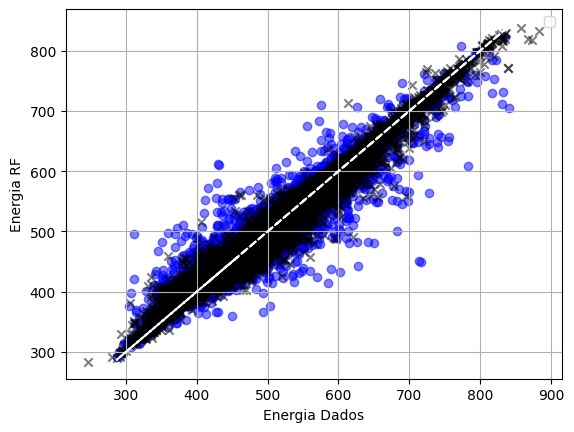

c:\Users\profr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
c:\Users\profr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
c:\Users\profr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
PermutationExplainer explainer:   1%|          | 2/300 [00:00<?, ?it/s]c:\Users\profr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
c:\Users\profr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature 

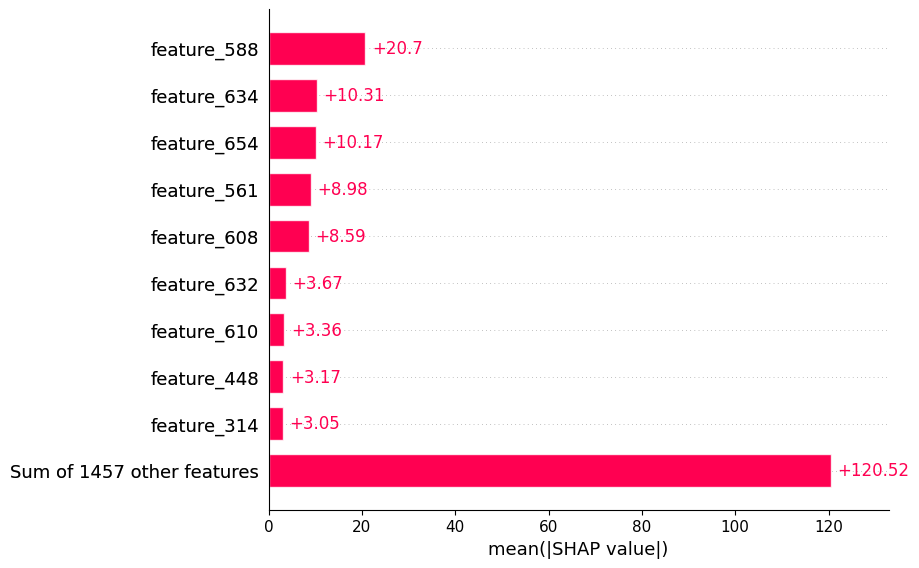

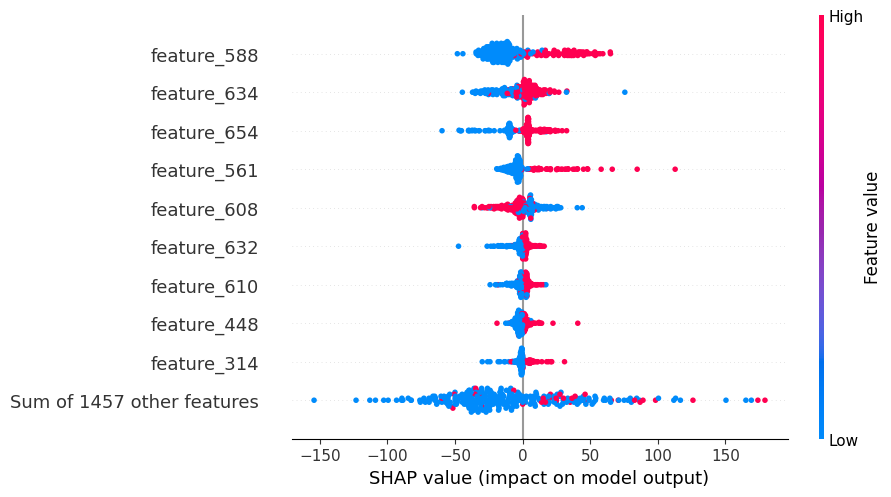

Start of training Fri Jan 31 18:11:05 2025
End of training Fri Jan 31 19:25:16 2025


In [28]:
##################### Wl - ExtraTreesRegressor ####################
hiperParams = {'max_depth': 17, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 400, 'random_state': 42}
ExtraTreesRegressorToWl(hiperParams, 'blue')

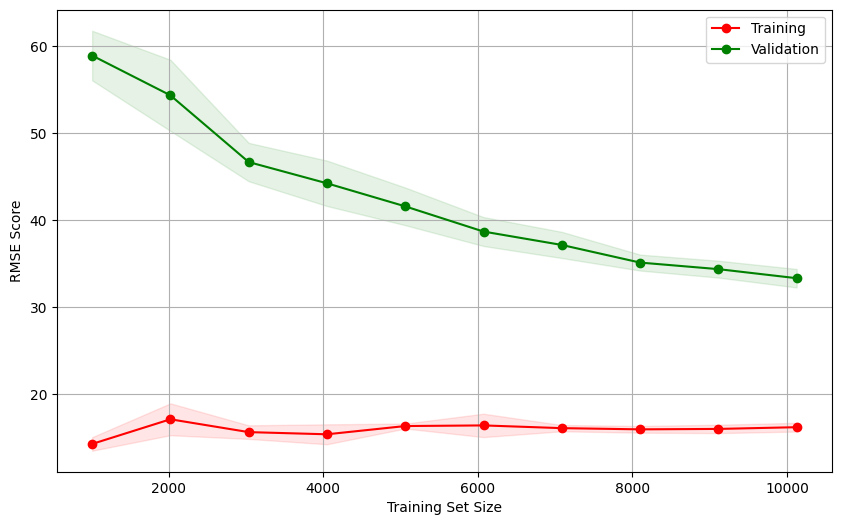

In [8]:
# Define RMSE as the scoring metric
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=True, squared=False)

# Hyperparameters for the model
hiperParams = {'max_depth': 17, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 400, 'random_state': 42}
regr = ExtraTreesRegressor(**hiperParams)

# Compute the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    regr, X_train_WL_scaled, y_train_WL, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10), scoring=rmse_scorer
)

# Compute mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.xlabel("Training Set Size")
plt.ylabel("RMSE Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training")

plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation")

plt.legend(loc="best")
plt.show()


Cross Validation:::


Média do MSE: 0.052200281281699255
Média do MAE: 0.17075972396070452
Média do R²: 0.46446908010704546
Média do RMSE: 0.22843518282461447
Média do MAPE: 1403.6330473090784
Fold 1: MSE = 0.049507676572957356, MAE = 0.1685546921198824, R² = 0.4892811269283365, RMSE = 0.2225032057588325, MAPE = 1389.0320901680382
Fold 2: MSE = 0.053414437200259665, MAE = 0.1756506444579121, R² = 0.4559129456371843, RMSE = 0.23111563599259066, MAPE = 1509.2621417657751
Fold 3: MSE = 0.05367873007188073, MAE = 0.16807383530431907, R² = 0.4482131677556156, RMSE = 0.23168670672242017, MAPE = 1312.6049099934219


 Test model evaluation results:
MAE: 0.15953824665138966
MSE: 0.04685802934800284
RMSE: 0.21646715535619449
R2: 0.5125263506290614
MAPE: 1232.3928664793775
Training model evaluation results:
MAE: 0.11437238538105311
MSE: 0.02573334429915201
RMSE: 0.1604161597194996
R2: 0.7360625945110663
MAPE: 900.1819981934141


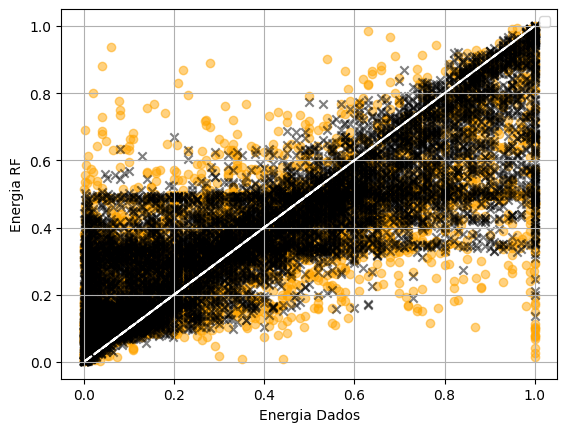

c:\Users\profr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
c:\Users\profr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
c:\Users\profr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
c:\Users\profr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warnings.warn(
c:\Users\profr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but ExtraTreesRegressor was fitted without feature names
  warni

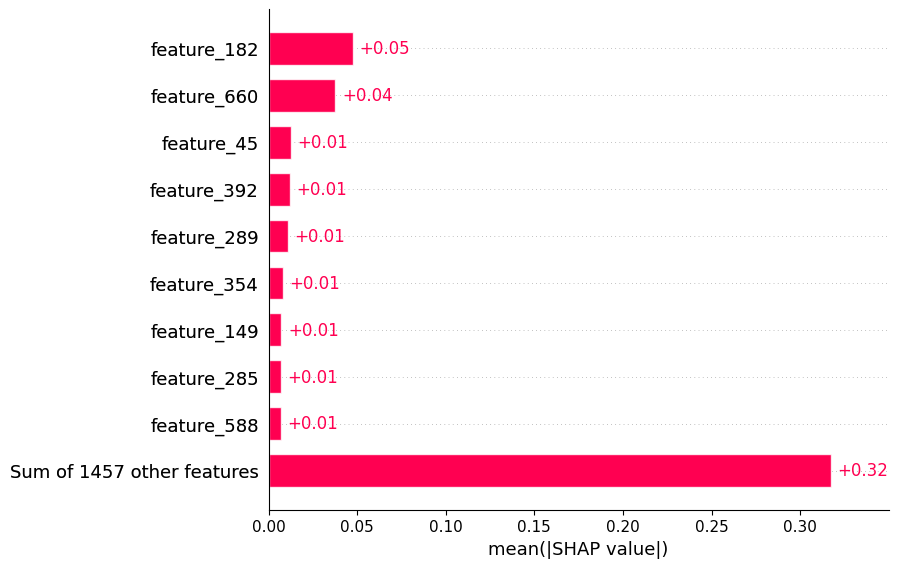

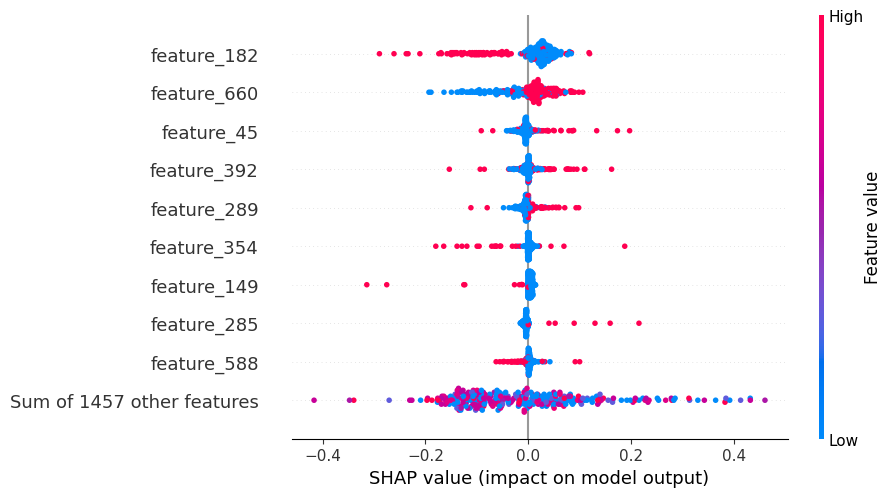

Start of training Fri Jan 31 19:25:17 2025
End of training Fri Jan 31 20:21:54 2025


In [29]:
##################### QY - ExtraTreesRegressor - ####################
hiperParams = {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 400, 'random_state': 60}
ExtraTreesRegressorToQy(hiperParams, 'orange')

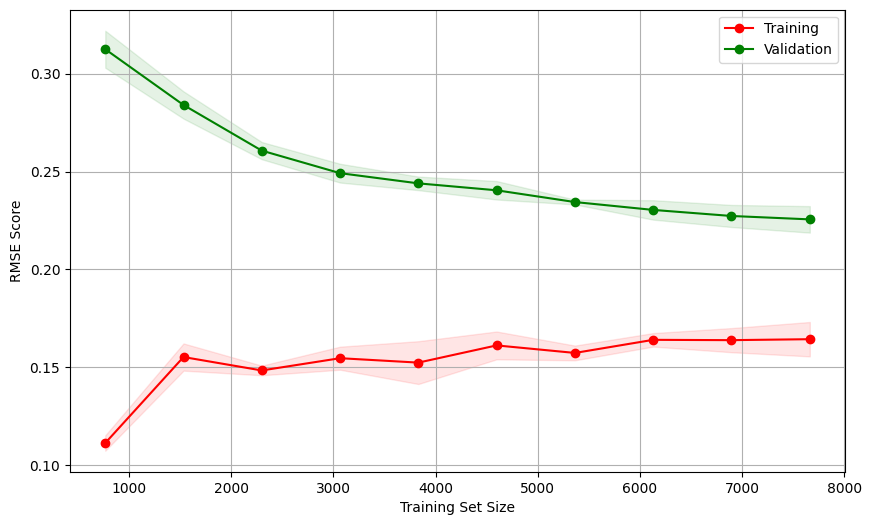

In [9]:
# Define RMSE as the scoring metric
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=True, squared=False)

hiperParams = {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 400, 'random_state': 60}
regr = ExtraTreesRegressor(**hiperParams)

# Compute the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    regr, X_train_QY_scaled, y_train_QY, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10), scoring=rmse_scorer
)

# Compute mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.xlabel("Training Set Size")
plt.ylabel("RMSE Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training")

plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation")

plt.legend(loc="best")
plt.show()


## Below we have the test with random forest

In [96]:
##################### func - RandomForestRegressor ####################

def RandomForestRegressorToWL(hiperParams, color):
    inicio = time.ctime()

    regr = RandomForestRegressor(**hiperParams)

    try:
        ###------- CrossValidation -------###
        funcCrossValidation(regr, X_train_WL_scaled, y_train_WL)

        ###------- Testing Overfiting and final result -------###
        regr.fit(X_train_WL_scaled, y_train_WL)
        joblib.dump(regr, f'{color}_Random.pkl')
        print(color)
        y_pred = regr.predict(X_test_WL_scaled)
        y_pred2 = regr.predict(X_train_WL_scaled)
        resultados = avaliar_modelo(y_test_WL, y_pred)

        
        # print test results
        print("\n\n Test model evaluation results:")
        for metrica, valor in resultados.items():
            print(f"{metrica}: {valor}")

        y_pred2 = regr.predict(X_train_WL_scaled)
        resultados = avaliar_modelo(y_train_WL, y_pred2)

        # print training results
        print("Training model evaluation results:")
        for metrica, valor in resultados.items():
            print(f"{metrica}: {valor}")
        
        ###------- draw graph test -------###
        grafic(y_test_WL, y_pred, y_train_WL, y_pred2, color)
        

        ###------- Shap - importances values -------###

        funcImportances(regr, X_test_WL_scaled,"random_wl")
    except Exception as e:
        # print error
        print(f"Ocorreu um erro: {e}")

    print('Start of training', inicio)
    print('End of training', time.ctime())

##################### func - RandomForestRegressor ####################

def RandomForestRegressorToQY(hiperParams, color):
    inicio = time.ctime()

    regr = RandomForestRegressor(**hiperParams)

    try:
        ###------- CrossValidation -------###
        funcCrossValidation(regr, X_train_QY_scaled, y_train_QY)

        ###------- Testing Overfiting and final result -------###
        regr.fit(X_train_QY_scaled, y_train_QY)
        joblib.dump(regr, f'{color}_Random.pkl')
        print(color)
        y_pred = regr.predict(X_test_QY_scaled)
        y_pred2 = regr.predict(X_train_QY_scaled)
        resultados = avaliar_modelo(y_test_QY, y_pred)

        
        # print test results
        print("\n\n Test model evaluation results:")
        for metrica, valor in resultados.items():
            print(f"{metrica}: {valor}")

        y_pred2 = regr.predict(X_train_QY_scaled)
        resultados = avaliar_modelo(y_train_QY, y_pred2)

        # print training results
        print("Training model evaluation results:")
        for metrica, valor in resultados.items():
            print(f"{metrica}: {valor}")
        
        ###------- draw graph test -------###
        grafic(y_test_QY, y_pred, y_train_QY, y_pred2, color)
        

        ###------- Shap - importances values -------###

        funcImportances(regr, X_test_QY_scaled, 'random_qy')
    except Exception as e:
        # print error
        print(f"Ocorreu um erro: {e}")

    print('Start of training', inicio)
    print('End of training', time.ctime())

Cross Validation:::


Média do MSE: 1159.7230189088293
Média do MAE: 22.702345241552347
Média do R²: 0.8691460828382404
Média do RMSE: 34.04932609984167
Média do MAPE: 4.578930573245269
Fold 1: MSE = 1102.0714374800452, MAE = 22.34592455118116, R² = 0.8744719155971675, RMSE = 33.19746131076961, MAPE = 4.562261457873899
Fold 2: MSE = 1183.5001582906389, MAE = 22.99890654851776, R² = 0.8697292076667203, RMSE = 34.402037124139014, MAPE = 4.632241376924981
Fold 3: MSE = 1193.5974609558036, MAE = 22.76220462495812, R² = 0.8632371252508331, RMSE = 34.54847986461638, MAPE = 4.5422888849369265
blue


 Test model evaluation results:
MAE: 18.55918560265064
MSE: 828.6207065203529
RMSE: 28.785772640670128
R2: 0.9047373773387396
MAPE: 3.7678304460418652
Training model evaluation results:
MAE: 9.553204958963176
MSE: 219.01050191843947
RMSE: 14.799003409636727
R2: 0.9753021795312459
MAPE: 1.9244592664088536


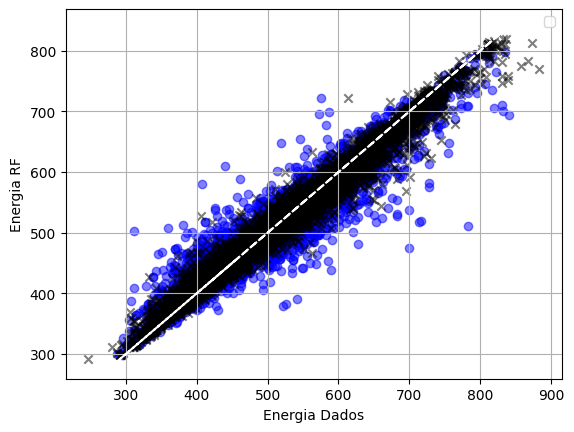

c:\Users\profr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\profr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\profr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\profr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\profr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature nam

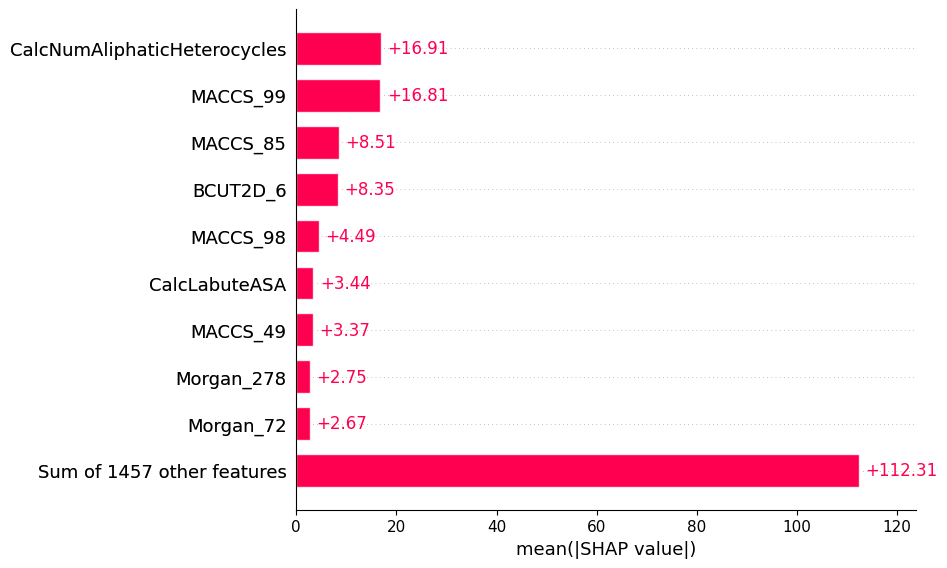

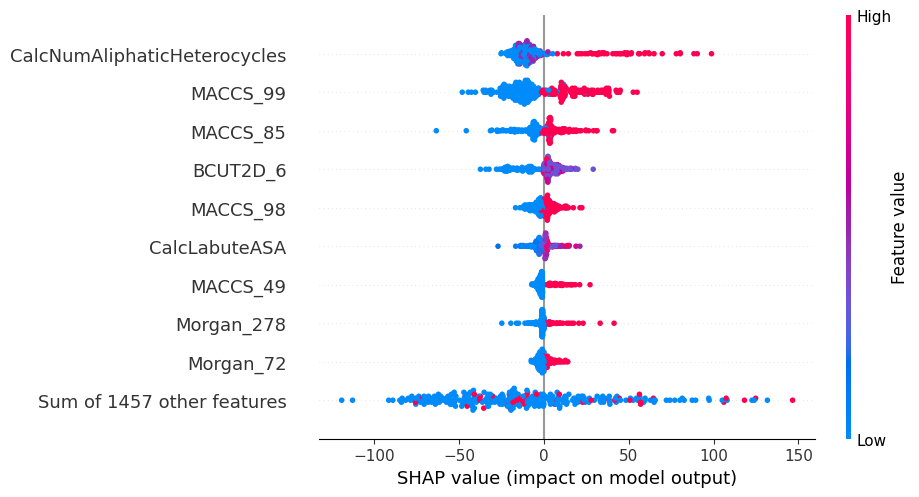

Start of training Sun Feb  2 10:25:03 2025
End of training Sun Feb  2 10:48:32 2025


In [88]:
##################### Wl - Random Forest ####################
hiperParams = {'max_leaf_nodes': 10000, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 42}
RandomForestRegressorToWL(hiperParams, 'blue')

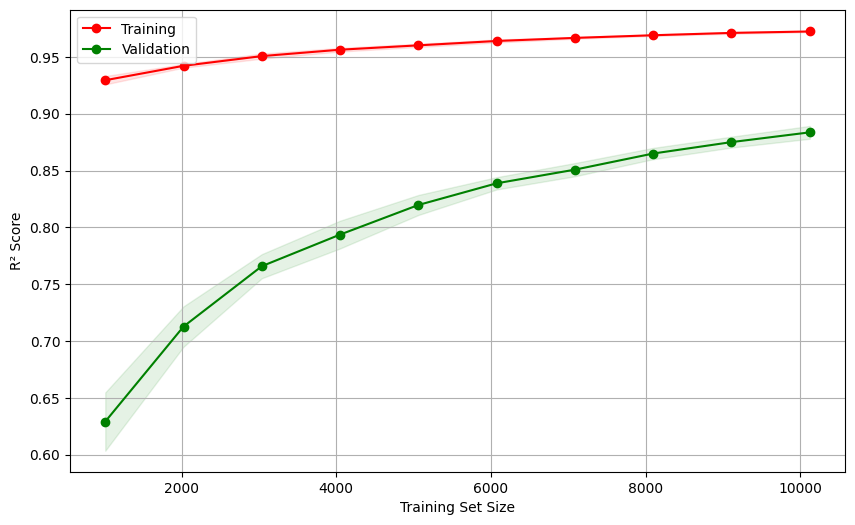

In [10]:
# Learning Curve
hyper_params = {'max_leaf_nodes': 10000, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 42}
regr = RandomForestRegressor(**hyper_params)
train_sizes, train_scores, test_scores = learning_curve(regr, X_train_WL_scaled, y_train_WL, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training")

plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation")

plt.legend(loc="best")
plt.show()


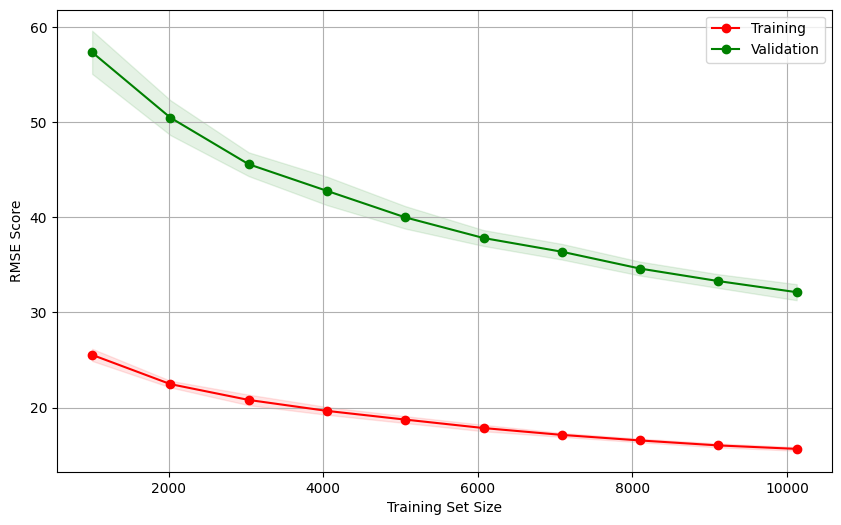

In [7]:
# Define RMSE as the scoring metric
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=True, squared=False)

# Hyperparameters for the model
hyper_params = {'max_leaf_nodes': 10000, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 42}
regr = RandomForestRegressor(**hyper_params)

# Compute the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    regr, X_train_WL_scaled, y_train_WL, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10), scoring=rmse_scorer
)

# Compute mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.xlabel("Training Set Size")
plt.ylabel("RMSE Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training")

plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation")

plt.legend(loc="best")
plt.show()


Cross Validation:::


Média do MSE: 0.044362033566672586
Média do MAE: 0.15745149991985433
Média do R²: 0.5448272369454471
Média do RMSE: 0.21062288152589073
Média do MAPE: 1352.2272463867637
Fold 1: MSE = 0.044270996691421954, MAE = 0.15644504472048307, R² = 0.5433024713514294, RMSE = 0.21040674107884935, MAPE = 1203.410994299311
Fold 2: MSE = 0.04446406419181706, MAE = 0.1591832676647353, R² = 0.5470827180969102, RMSE = 0.21086503786027938, MAPE = 1354.6251324013851
Fold 3: MSE = 0.04435103981677874, MAE = 0.15672618737434463, R² = 0.5440965213880018, RMSE = 0.2105968656385435, MAPE = 1498.6456124595948
orange


 Test model evaluation results:
MAE: 0.13769398113437117
MSE: 0.03609169471536552
RMSE: 0.18997814273059288
R2: 0.6245307286779671
MAPE: 966.6615504988758
Training model evaluation results:
MAE: 0.06991151773818009
MSE: 0.009472141865740866
RMSE: 0.09732492931279665
R2: 0.9028477402935484
MAPE: 584.1494849552723


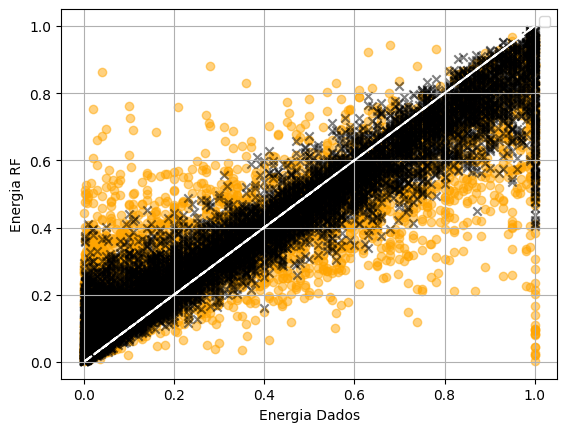

c:\Users\profr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\profr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\profr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\profr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\profr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature nam

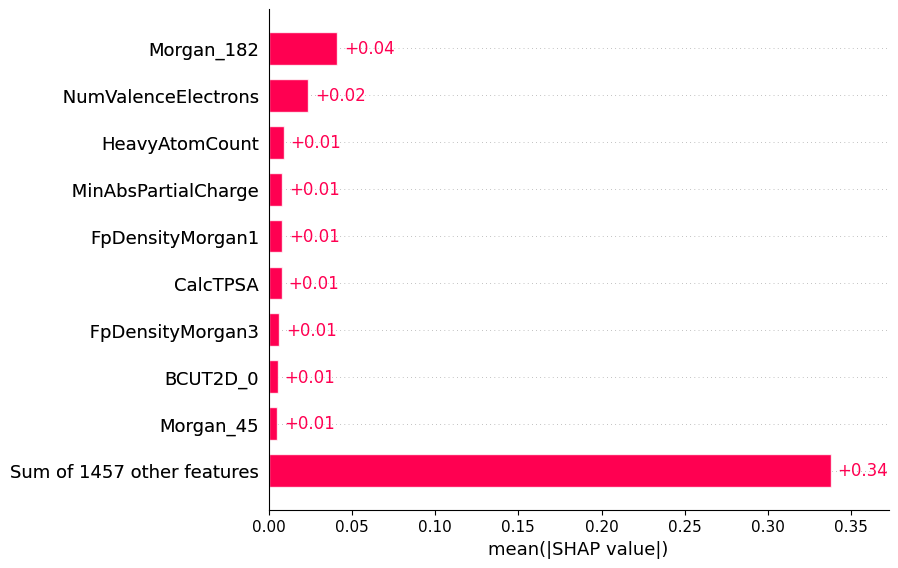

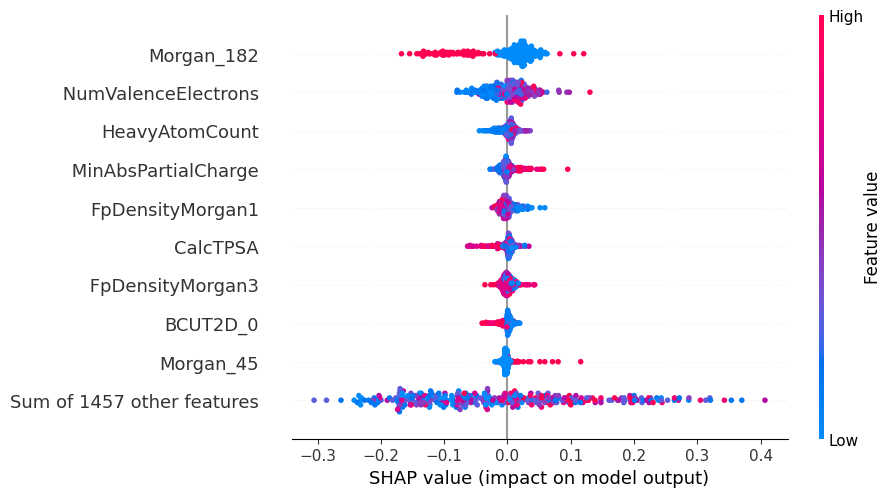

Start of training Sun Feb  2 17:29:53 2025
End of training Sun Feb  2 17:52:48 2025


In [99]:
##################### QY - Random Forest - ####################
hiperParams = {'max_leaf_nodes': 10000, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 42}
RandomForestRegressorToQY(hiperParams, 'orange')

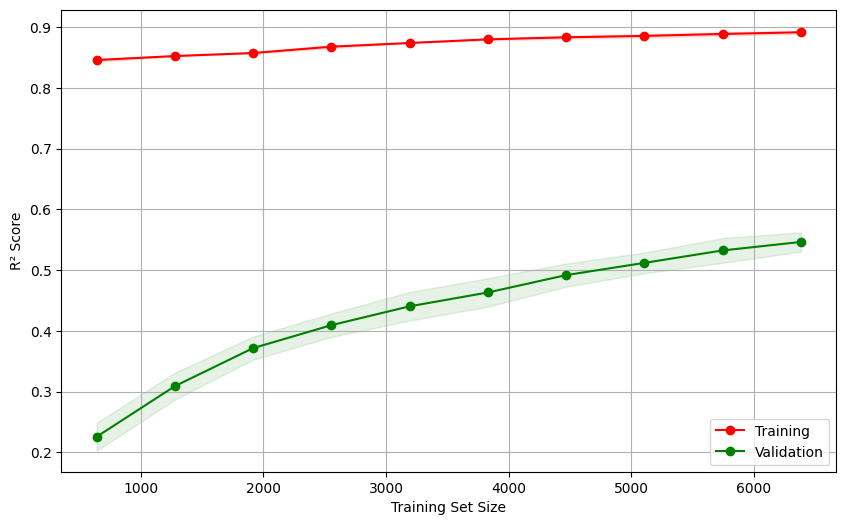

In [7]:
# Learning Curve
hiperParams = {'max_leaf_nodes': 10000, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 42}
regr = RandomForestRegressor(**hiperParams)

train_sizes, train_scores, test_scores = learning_curve(regr, X_train_QY_scaled, y_train_QY, cv=3, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.1,
                color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training")

plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation")

plt.legend(loc="best")
plt.show()

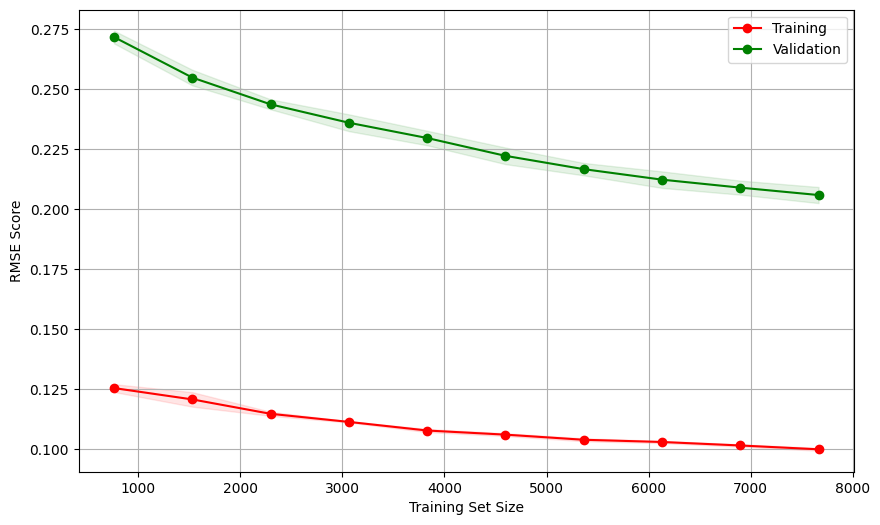

In [8]:
# Define RMSE as the scoring metric
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=True, squared=False)

hiperParams = {'max_leaf_nodes': 10000, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 42}
regr = RandomForestRegressor(**hiperParams)

train_sizes, train_scores, test_scores = learning_curve(regr, X_train_QY_scaled, y_train_QY, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring=rmse_scorer)


# Compute mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.xlabel("Training Set Size")
plt.ylabel("RMSE Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training")

plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation")

plt.legend(loc="best")
plt.show()


In [ ]:
# Define RMSE as the scoring metric
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=True, squared=False)

hiperParams = {'max_leaf_nodes': 10000, 'min_samples_split': 7, 'n_estimators': 100, 'random_state': 42}
regr = RandomForestRegressor(**hiperParams)

train_sizes, train_scores, test_scores = learning_curve(regr, X_train_QY_scaled, y_train_QY, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring=rmse_scorer)


# Compute mean and standard deviation for training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title("Sensitivity - Random Forest")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training")

plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation")

plt.legend(loc="best")
plt.show()


## Below we have the test with XGB

In [7]:
##################### func - XGB ####################

def funcXGBWL(hiperParams, color):
    
    inicio = time.ctime()

    regr = regr = xgb.XGBRegressor(**hiperParams)

    try:
        ###------- CrossValidation -------###
        funcCrossValidation(regr, X_train_WL_scaled, y_train_WL)

        ###------- Testing Overfiting and final result -------###
        regr.fit(X_train_WL_scaled, y_train_WL)
        joblib.dump(regr, f'{color}_XGB_model.pkl')

        y_pred = regr.predict(X_test_WL)
        resultados = avaliar_modelo(y_test_WL, y_pred)

        
        # print test results
        print("\n\n Test model evaluation results:")
        for metrica, valor in resultados.items():
            print(f"{metrica}: {valor}")

        y_pred2 = regr.predict(X_train_WL_scaled)
        resultados = avaliar_modelo(y_train_WL, y_pred2)

        # print training results
        print("Training model evaluation results:")
        for metrica, valor in resultados.items():
            print(f"{metrica}: {valor}")
        
        ###------- draw graph test -------###
        grafic(y_test_WL, y_pred, y_train_WL, y_pred2, color)
        

        ###------- Shap - importances values -------###

        #funcImportances(regr, X_test_WL_scaled)
    except Exception as e:
        # print error
        print(f"Ocorreu um erro: {e}")

    print('Start of training', inicio)
    print('End of training', time.ctime())

##################### func - XGB ####################

def funcXGBQY(hiperParams, color):
    
    inicio = time.ctime()

    regr = regr = xgb.XGBRegressor(**hiperParams)

    #try:
    ###------- CrossValidation -------###
    funcCrossValidation(regr, X_train_QY_scaled, y_train_QY)

    ###------- Testing Overfiting and final result -------###
    regr.fit(X_train_QY_scaled, y_train_QY)
    joblib.dump(regr, f'{color}_XGB_model.pkl')

    y_pred = regr.predict(X_test_QY)
    resultados = avaliar_modelo(y_test_QY, y_pred)

    
    # print test results
    print("\n\n Test model evaluation results:")
    for metrica, valor in resultados.items():
        print(f"{metrica}: {valor}")

    y_pred2 = regr.predict(X_train_QY_scaled)
    resultados = avaliar_modelo(y_train_QY, y_pred2)

    # print training results
    print("Training model evaluation results:")
    for metrica, valor in resultados.items():
        print(f"{metrica}: {valor}")
    
    ###------- draw graph test -------###
    grafic(y_test_QY, y_pred,y_train_QY,y_pred2, color)
    

    ###------- Shap - importances values -------###

    #funcImportances(regr, X_test_QY_scaled)
    #except Exception as e:
    #    # print error
    #    print(f"Ocorreu um erro: {e}")
#
    print('Start of training', inicio)
    print('End of training', time.ctime())

Cross Validation:::


Média do MSE: 1079.33878706382
Média do MAE: 23.006493464961466
Média do R²: 0.8782159884770712
Média do RMSE: 32.84892192775474
Média do MAPE: 4.661672684748614
Fold 1: MSE = 1029.9723697501302, MAE = 22.79131962174232, R² = 0.8826841115951538, RMSE = 32.09318260550253, MAPE = 4.676185629915094
Fold 2: MSE = 1100.8236311247847, MAE = 23.13077455089238, R² = 0.8788295984268188, RMSE = 33.178662286547734, MAPE = 4.680904230911589
Fold 3: MSE = 1107.2203603165456, MAE = 23.097386222249696, R² = 0.8731342554092407, RMSE = 33.27492089121394, MAPE = 4.627928193419159


 Test model evaluation results:
MAE: 84.14833599416907
MSE: 9773.63840740419
RMSE: 98.86171355688809
R2: -0.12362921237945557
MAPE: 18.5844808499815
Training model evaluation results:
MAE: 15.712341156669023
MSE: 470.5001618595118
RMSE: 21.691015694510753
R2: 0.9469416737556458
MAPE: 3.211737643293949


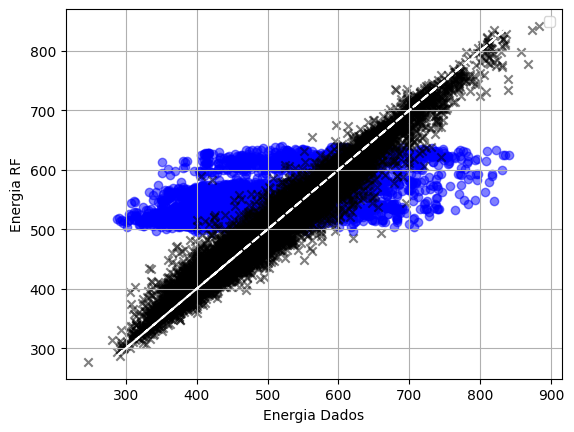

Start of training Wed Feb  5 15:08:35 2025
End of training Wed Feb  5 15:09:19 2025


In [8]:
##################### Wl - XGB ####################
hiperParams = {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'reg_alpha': 1.0, 'reg_lambda': 1.0, 'subsample': 1.0}
funcXGBWL(hiperParams, 'blue')

Cross Validation:::


Média do MSE: 0.04368401210068366
Média do MAE: 0.1543365780654968
Média do R²: 0.5517841513114988
Média do RMSE: 0.2090060005472664
Média do MAPE: 1309.0865215104077
Fold 1: MSE = 0.04332160936096983, MAE = 0.15170146069560952, R² = 0.553096306592364, RMSE = 0.20813843797090875, MAPE = 1260.2008066223875
Fold 2: MSE = 0.04368202595674639, MAE = 0.1554300771245415, R² = 0.5550486707872556, RMSE = 0.20900245442756502, MAPE = 1290.5077921224129
Fold 3: MSE = 0.04404840098433476, MAE = 0.15587819637633937, R² = 0.5472074765548767, RMSE = 0.20987710924332545, MAPE = 1376.550965786423


 Test model evaluation results:
MAE: 0.2591254508406624
MSE: 0.10548159442276928
RMSE: 0.32477930109963793
R2: -0.09734656984511392
MAPE: 1951.4425273743193
Training model evaluation results:
MAE: 0.09631738402511024
MSE: 0.01715001761669518
RMSE: 0.13095807579792543
R2: 0.8240986052485532
MAPE: 734.0516847828696


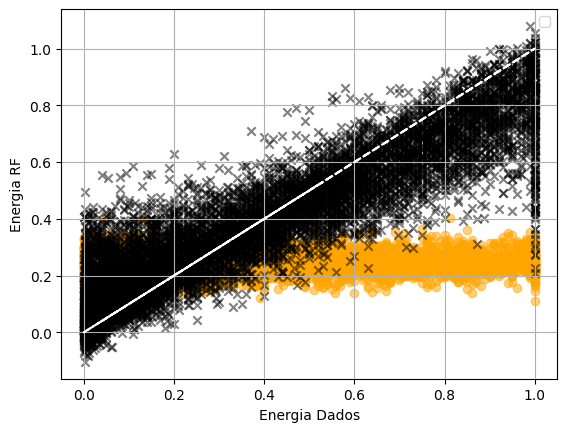

Start of training Sat Feb  1 09:25:54 2025
End of training Sat Feb  1 09:26:06 2025


In [70]:
##################### QY - XGB ####################
hiperParams = {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 0.8}
funcXGBQY(hiperParams, 'orange')

Start of training Sat Feb  1 09:12:17 2025
8858


c:\Users\profr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 16)             │        23,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,617 (92.25 KB)

 Trainable params: 23,617 (92.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
4429/4429 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 177.8987 - mean_squared_error: 68999.4375 - val_loss: 53.0487 - val_mean_squared_error: 6360.8340
Epoch 2/20
4429/4429 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 45.8143 - mean_squared_error: 4921.5884 - val_loss: 42.8859 - val_mean_squared_error: 4011.4990
Epoch 3/20
4429/4429 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 38.4917 - mean_squared_error: 3222.8699 - val_loss: 40.4874 - val_mean_squared_error: 3466.5090
Epoch 4/20
4429/4429 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 35.0385 - mean_squared_error: 2502.5229 - val_loss: 40.0613 - val_mean_squared_error: 3266.2573
Epoch 5/20
4429/4429 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 32.4716 - mean_squared_error: 2142.2375 - val_loss: 37.6214 - val_mean_squared_error: 2945.5190
Epoch 6/20
4429/4429 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 30.7536 - mean_squared_error: 1898.9034 - val_loss: 36.7679 - val_mean_squared_error: 2829.3145
Epoch 7/20
4429/4429 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/s

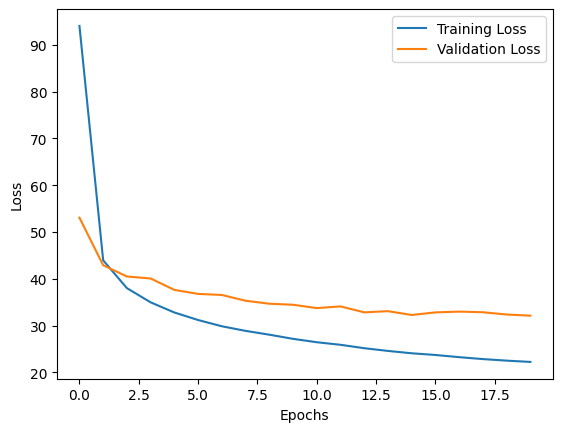

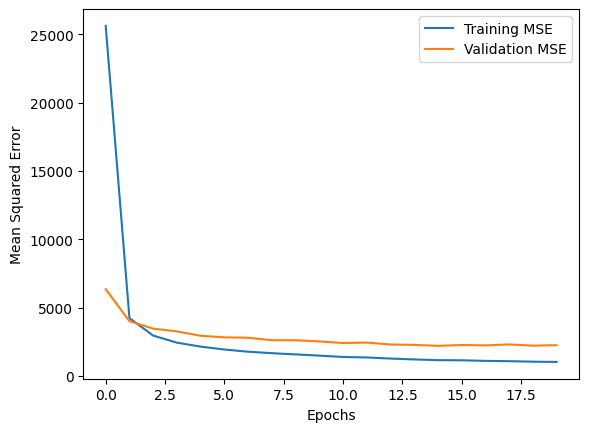

170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
5424
Resultados da avaliação do modelo de teste:
MAE: 30.841076696165192
MSE: 2062.8919616519174
RMSE: 45.41907046221793
R2: 0.7628390203293007
MAPE: 20.755840850682066
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step
Resultados da avaliação do modelo de treinamento:
MAE: 21.888426893746296
MSE: 996.7194498171859
RMSE: 31.57086393840349
R2: 0.8885709109534035
MAPE: 20.78651315694979
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
Resultados da avaliação do modelo de validação:
MAE: 32.11905960914867
MSE: 2256.8160318907676
RMSE: 47.505957856786424
R2: 0.7401907081205072
MAPE: 20.680112048578223
Start of training Sat Feb  1 09:14:06 2025
End of training Sat Feb  1 09:14:08 2025


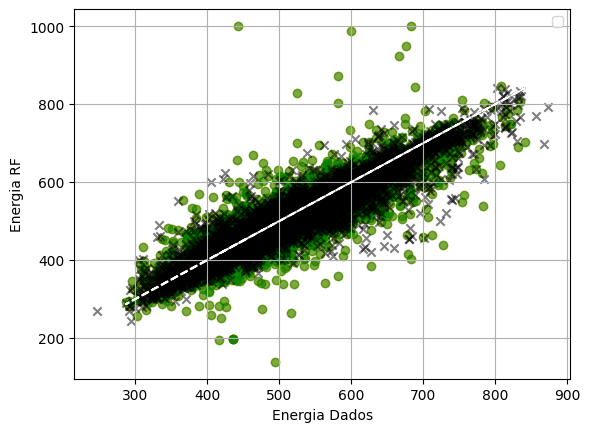

In [57]:
##################### RNA - WL ####################
print('Start of training', time.ctime())
inicio = time.ctime()
rad = 2
n_est = 1000
sizeleaf = 5
m_fac = 733

X_train, X_val, y_train, y_val = train_test_split(X_train_WL_scaled, y_train_WL, test_size=0.3, random_state=200) 

len_train = len(X_train)
print(len_train)

m_node = ceil(len_train/sizeleaf)

modelo2 = Sequential()
modelo2.add(Dense(units=16, input_dim=len(X_train_WL_scaled[0]), activation='relu'))
modelo2.add(Dense(units=8, activation='relu'))
modelo2.add(Dense(units=1, activation='linear'))
modelo2.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])
modelo2.summary()

history2 = modelo2.fit(X_train, y_train, epochs=20, batch_size=2, validation_data=(X_val, y_val))

print('Start of training', inicio)
print('End of training', time.ctime())


plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(history2.history['mean_squared_error'], label='Training MSE')
plt.plot(history2.history['val_mean_squared_error'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


inicio = time.ctime()
y_pred = modelo2.predict(X_test_WL_scaled)
resultados = avaliar_modelo(y_test_WL, np.round(y_pred))
print(len(y_pred))



print("Resultados da avaliação do modelo de teste:")
for metrica, valor in resultados.items():
    print(f"{metrica}: {valor}")


y_pred2 = modelo2.predict(X_train)
resultados = avaliar_modelo(y_train, y_pred2)



print("Resultados da avaliação do modelo de treinamento:")
for metrica, valor in resultados.items():
    print(f"{metrica}: {valor}")

y_pred3 = modelo2.predict(X_val)
resultados = avaliar_modelo(y_val, y_pred3)



print("Resultados da avaliação do modelo de validação:")
for metrica, valor in resultados.items():
    print(f"{metrica}: {valor}")

print('Start of training', inicio)
print('End of training', time.ctime())


############ Energy


plt.plot(y_test_WL, y_test_WL, linestyle='--', color='black', label='y = x')
plt.scatter(y_test_WL, y_pred, alpha=0.5, color='orange', label='Pontos de Teste vs. Previsões')

modelo2.save('WL-RNA.keras')
grafic(y_test_WL, y_pred,y_train,y_pred2, 'green')


Start of training Sat Feb  1 09:14:09 2025


c:\Users\profr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 16)             │        23,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,617 (92.25 KB)

 Trainable params: 23,617 (92.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
3353/3353 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.5188 - mean_squared_error: 2.0608 - val_loss: 0.2818 - val_mean_squared_error: 0.1579
Epoch 2/20
3353/3353 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2865 - mean_squared_error: 0.1808 - val_loss: 0.2521 - val_mean_squared_error: 0.1204
Epoch 3/20
3353/3353 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2473 - mean_squared_error: 0.1220 - val_loss: 0.2401 - val_mean_squared_error: 0.1205
Epoch 4/20
3353/3353 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2212 - mean_squared_error: 0.0956 - val_loss: 0.2822 - val_mean_squared_error: 0.3593
Epoch 5/20
3353/3353 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2121 - mean_squared_error: 0.0971 - val_loss: 0.2309 - val_mean_squared_error: 0.1685
Epoch 6/20
3353/3353 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.1985 - mean_squared_error: 0.0740 - val_loss: 0.2157 - val_mean_squared_error: 0.1122
Epoch 7/20
3353/3353 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.1864 - mean_squared_error: 0.0670 - 

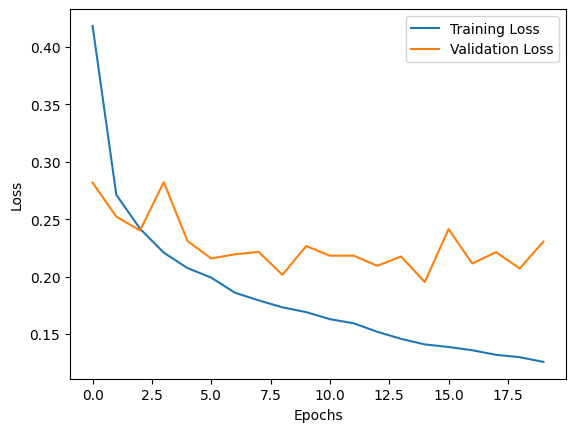

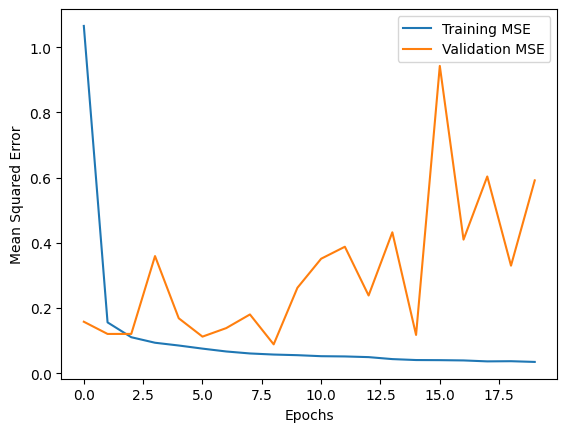

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
4106
Resultados da avaliação do modelo de teste:
MAE: 4.21840016804676
MSE: 59.13475883267436
RMSE: 7.6899127974687955
R2: -614.1909735415016
MAPE: 39545.228703509674
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Resultados da avaliação do modelo de treinamento:
MAE: 0.12394446966915848
MSE: 0.03362919189666735
RMSE: 0.18338263793682144
R2: 0.656411280972861
MAPE: 3539.671997008147
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
Resultados da avaliação do modelo de validação:
MAE: 0.2304524601275631
MSE: 0.5915690398869178
RMSE: 0.7691352546119036
R2: -5.12605824398844
MAPE: 3285.6236799008116
Start of training Sat Feb  1 09:15:35 2025
End of training Sat Feb  1 09:15:36 2025


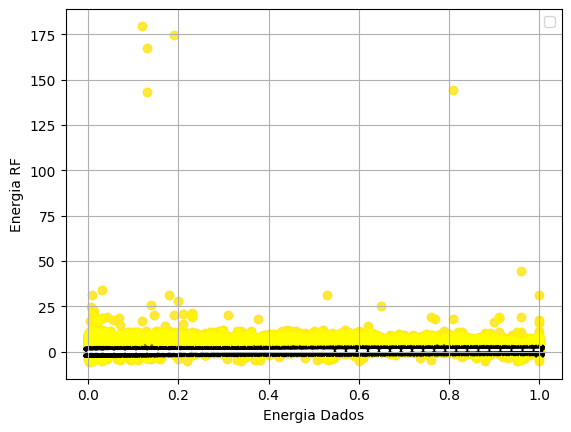

In [59]:
##################### RNA - QY ####################
print('Start of training', time.ctime())
inicio = time.ctime()
rad = 2
n_est = 1000
sizeleaf = 5
m_fac = 733

X_train, X_val, y_train, y_val = train_test_split(X_train_QY_scaled, y_train_QY, test_size=0.3, random_state=200) 

m_node = ceil(len_train/sizeleaf)

modelo3 = Sequential()
modelo3.add(Dense(units=16, input_dim=len(X_train_QY_scaled[0]), activation='relu'))
modelo3.add(Dense(units=8, activation='relu'))
modelo3.add(Dense(units=1, activation='linear'))
modelo3.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])
modelo3.summary()

history2 = modelo3.fit(X_train, y_train, epochs=20, batch_size=2, validation_data=(X_val, y_val))


print('Start of training', inicio)
print('End of training', time.ctime())


plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(history2.history['mean_squared_error'], label='Training MSE')
plt.plot(history2.history['val_mean_squared_error'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


inicio = time.ctime()
y_pred = modelo3.predict(X_test_QY)
resultados = avaliar_modelo(y_test_QY, np.round(y_pred))
print(len(y_pred))



print("Resultados da avaliação do modelo de teste:")
for metrica, valor in resultados.items():
    print(f"{metrica}: {valor}")


y_pred2 = modelo3.predict(X_train)
resultados = avaliar_modelo(y_train, y_pred2)



print("Resultados da avaliação do modelo de treinamento:")
for metrica, valor in resultados.items():
    print(f"{metrica}: {valor}")

y_pred3 = modelo3.predict(X_val)
resultados = avaliar_modelo(y_val, y_pred3)



print("Resultados da avaliação do modelo de validação:")
for metrica, valor in resultados.items():
    print(f"{metrica}: {valor}")

print('Start of training', inicio)
print('End of training', time.ctime())


############ Gráfico Energy

plt.plot(y_test_QY, y_test_QY, linestyle='--', color='black', label='y = x')
plt.scatter(y_test_QY, y_pred, alpha=0.5, color='orange', label='Pontos de Teste vs. Previsões')

modelo3.save('QY-RNA.keras')
grafic(y_test_QY, y_pred, y_train, y_pred2, 'yellow')
